# Random Forest for HAMBI data 

## Load libraries

In [186]:
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from datetime import datetime
import joblib

# Set seed
seed = 98

# Set font
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from copy import copy

# List all font names
#available_fonts = sorted(set(f.name for f in fm.fontManager.ttflist))
#for font in available_fonts:
#    print(font)

## Import data

In [ ]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'

In [ ]:
data = pd.read_csv("/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv", sep="\t", index_col=0, header=0,low_memory=False)

In [ ]:
data.head()

In [72]:
data['Domain to species'].value_counts(dropna=False)

Domain to species
NaN                                                                                                                           658
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Citrobacter_Citrobacter_B_koseri              253
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhizobiales_Beijerinckiaceae_Microvirga_Microvirga_lotononidis                    157
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_C_Bordetella_Bordetella_avium                    154
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_B_Comamonas_Comamonas_testosteroni_C             147
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_Cupriavidus_Cupriavidus_oxalaticus               116
Bacteria_Pseudomonadota_Gammaproteobacteria_Pseudomonadales_Pseudomonadaceae_Pseudomonas_E_Pseudomonas_E_putida               111
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacte

In [ ]:
len(data['Domain to species'].value_counts(dropna=False))

In [ ]:
len(data.value_counts(dropna=False))

## Random forest classifier

In [94]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['s'].unique())
    print(f"before filtering number of classes {len(data['s'].value_counts())}")   
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"after filtering number of classes {len(data_filtered['s'].value_counts())}")
    classes_after = set(data_filtered['s'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    """Filter out the contigs that have less than n samples in the given column.
    
    Parameters:
    - data (pd.DataFrame): Data frame with the data.
    - column_name (str): Column name to filter out.
    - n (int): Minimum number of samples.
    """
    print(f"before filtering number of classes {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"after filtering number of classes {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model: RandomForestClassifier, title: str, output_dir: str, target: str):
    """Plot the confusion matrix for the given true and predicted values.
    
    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (pd.Series): Predicted labels.
    - model (RandomForestClassifier): Trained model.
    - title (str): Title of the plot.
    - output_dir (str): Path to the output directory where the plot will be saved.
    - target (str): Target colu<mn.
    """

    cm = confusion_matrix(y_true, y_pred)

    labels = ["Citrobacter_B_koseri", "Pseudomonas_E_putida", "Bordetella_avium", "Microvirga_lotononidis", "Paracoccus_denitrificans",
             "Comamonas_testosteroni_C", "Pseudomonas_E_chlororaphis", "Morganella_morganii", "Cupriavidus_oxalaticus",
              "Sphingobium_yanoikuyae", "Aeromonas_caviae"]

    # Replace underscores with spaces
    clean_labels = [label.replace("_", " ") for label in labels]

    plt.figure(figsize=(50, 50))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True,
                annot_kws={"size": 50})
    plt.xticks(rotation=90, fontsize=40, fontstyle='italic')
    plt.yticks(rotation=0, fontsize=40, fontstyle='italic')
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}', fontsize=80)
    plt.xlabel('Predicted Labels', fontsize=50)
    plt.ylabel('True Labels', fontsize=50)
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    title = title.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.savefig(os.path.join(output_dir, f'{title}.jpg'))

    # Edit when you have chosen the number of features
    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat.png'), bbox_inches='tight')
    plt.show()
    
    plt.close()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, output_dir: str, target: str):
    """Plot the distribution of the train and test sets.
    
    Parameters:
    - y_train (pd.Series): True labels of the train set.
    - y_test (pd.Series): True labels of the test set.
    - output_dir (str): Path to the output directory.
    """
    print("Plotting the distribution")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    print("Number of samples in each species in the train set:")
    print(train_species_counts)
    print("\nNumber of samples in each species in the test set:")
    print(test_species_counts)
    num_classes = len(set(y_train.unique()).union(set(y_test.unique())))
    
    width = max(12, num_classes * 0.6)
    height = max(8, num_classes * 0.8)
    
    plt.figure(figsize=(width, height))
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    labels = ["Citrobacter_B_koseri", "Pseudomonas_E_putida", "Bordetella_avium", "Microvirga_lotononidis", "Paracoccus_denitrificans",
             "Comamonas_testosteroni_C", "Pseudomonas_E_chlororaphis", "Morganella_morganii", "Cupriavidus_oxalaticus",
              "Sphingobium_yanoikuyae", "Aeromonas_caviae"]

    # Replace underscores with spaces
    clean_labels = [label.replace("_", " ") for label in labels]
    
    plt.xticks(indices, categories, rotation=90, fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)

    target = target.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.png'), bbox_inches='tight')

    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.jpg'))
    plt.show()

    plt.close()

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target:str, top_n: int = 30, output_dir: str = None):
    """Plot the feature importance of the model.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    - output_dir (str): Path to the output directory.
    """

# ***
    methylation_colors = {
        'm6A': 'skyblue',
        'm4C': 'lightcoral',
        'modified_base': 'lightgreen',
        'other': 'gray'
    }

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    top_features = X.columns[top_indices]

    def get_color(feature_name):
        if 'm6A' in feature_name:
            return methylation_colors['m6A']
        elif 'm4C' in feature_name:
            return methylation_colors['m4C']
        elif 'modified_base' in feature_name:
            return methylation_colors['modified_base']
        else:
            return methylation_colors['other']

    bar_colors = [get_color(feature) for feature in top_features]
# ***

    plt.figure(figsize=(20, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color=bar_colors)
    plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of {top_n} features with target {target}", fontsize=20)
    plt.tight_layout()
    output_name = f'{target.replace(" ", "_")}_feature_importance_colors.png'
#    output_name = f'{target.replace(" ", "_")}_feature_importance.png'
    plt.savefig(os.path.join(output_dir, output_name))
    plt.savefig(os.path.join(output_dir, output_name.replace('.png', '.jpg')))
    plt.close()

def train_test_model(df: pd.DataFrame, output_folder: str, target: str):
    """Train and test the random forest classifier.

    Parameters:
    - df (pd.DataFrame): Data frame with the data.
    - output_folder (str): Path to the output directory to save the results for the model plots
    - target (str): Target column.
    """
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10) ###### tätä muokkaa takasin 10
    
    X_DS = filtered_data.iloc[:, :492] 
    y_DS = filtered_data[target]

    X_train_DS, X_test_DS, y_train_DS, y_test_DS = train_test_split(X_DS, y_DS, test_size=0.2, random_state=seed, stratify=y_DS)
    plot_train_test_distribution(y_train_DS, y_test_DS, output_folder, target)
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train_DS, y_train_DS)

    y_train_pred_DS = model.predict(X_train_DS)
    y_test_pred_DS = model.predict(X_test_DS)

    plot_confusion_matrix(y_train_DS, y_train_pred_DS, model, f'Train Set with target {target}', output_folder, target)
    plot_confusion_matrix(y_test_DS, y_test_pred_DS, model, f'Test Set with target {target}', output_folder, target)

    plot_feature_importance(model, X_DS, target, 30, output_folder)

    metrics = pd.DataFrame({
            'Accuracy Train': [accuracy_score(y_train_DS, y_train_pred_DS)],
            'Accuracy Test': [accuracy_score(y_test_DS, y_test_pred_DS)],
            'Precision': [precision_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'Recall': [recall_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'F1 Score': [f1_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)]
        })
    
    metrics.to_csv(os.path.join(output_folder, f'{target.replace(" ", "_")}_metrics.tsv'), sep='\t')
    print(f"Metrics for target {target}")
    print(metrics)

    if accuracy_score(y_test_DS, y_test_pred_DS) > 0.7:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
        model_file_path = os.path.join(output_folder, f'{target.replace(" ", "_")}_model.joblib')
        print(f"Saving the model to {model_file_path}")
        joblib.dump(model, model_file_path)
    else:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
    return y_test_DS, y_test_pred_DS
    

Training the model with target: s
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 15
after filtering number of classes 11
Plotting the distribution
Number of samples in each species in the train set:
s
Citrobacter_B_koseri          185
Microvirga_lotononidis         78
Comamonas_testosteroni_C       78
Bordetella_avium               76
Pseudomonas_E_putida           74
Paracoccus_denitrificans       57
Morganella_morganii            47
Pseudomonas_E_chlororaphis     45
Cupriavidus_oxalaticus         38
Aeromonas_caviae               17
Sphingobium_yanoikuyae         17
Name: count, dtype: int64

Number of samples in each species in the test set:
s
Citrobacter_B_koseri          47
Microvirga_lotononidis        20
Comamonas_testosteroni_C      19
Bordetella_avium              19
Pseudomonas_E_putida          19
Paracoccus_denitrificans      14
Morganella_morganii           12
Pseudomonas_E_chlororaphis  

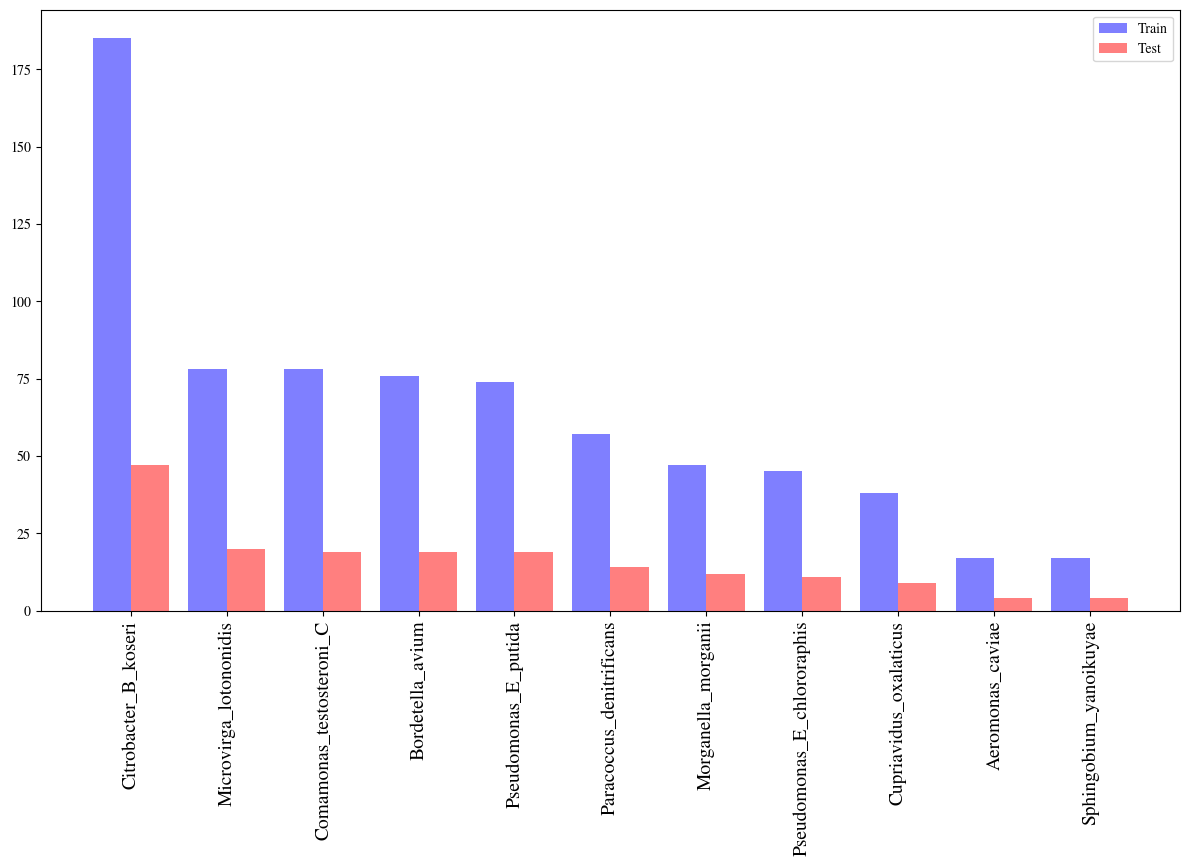

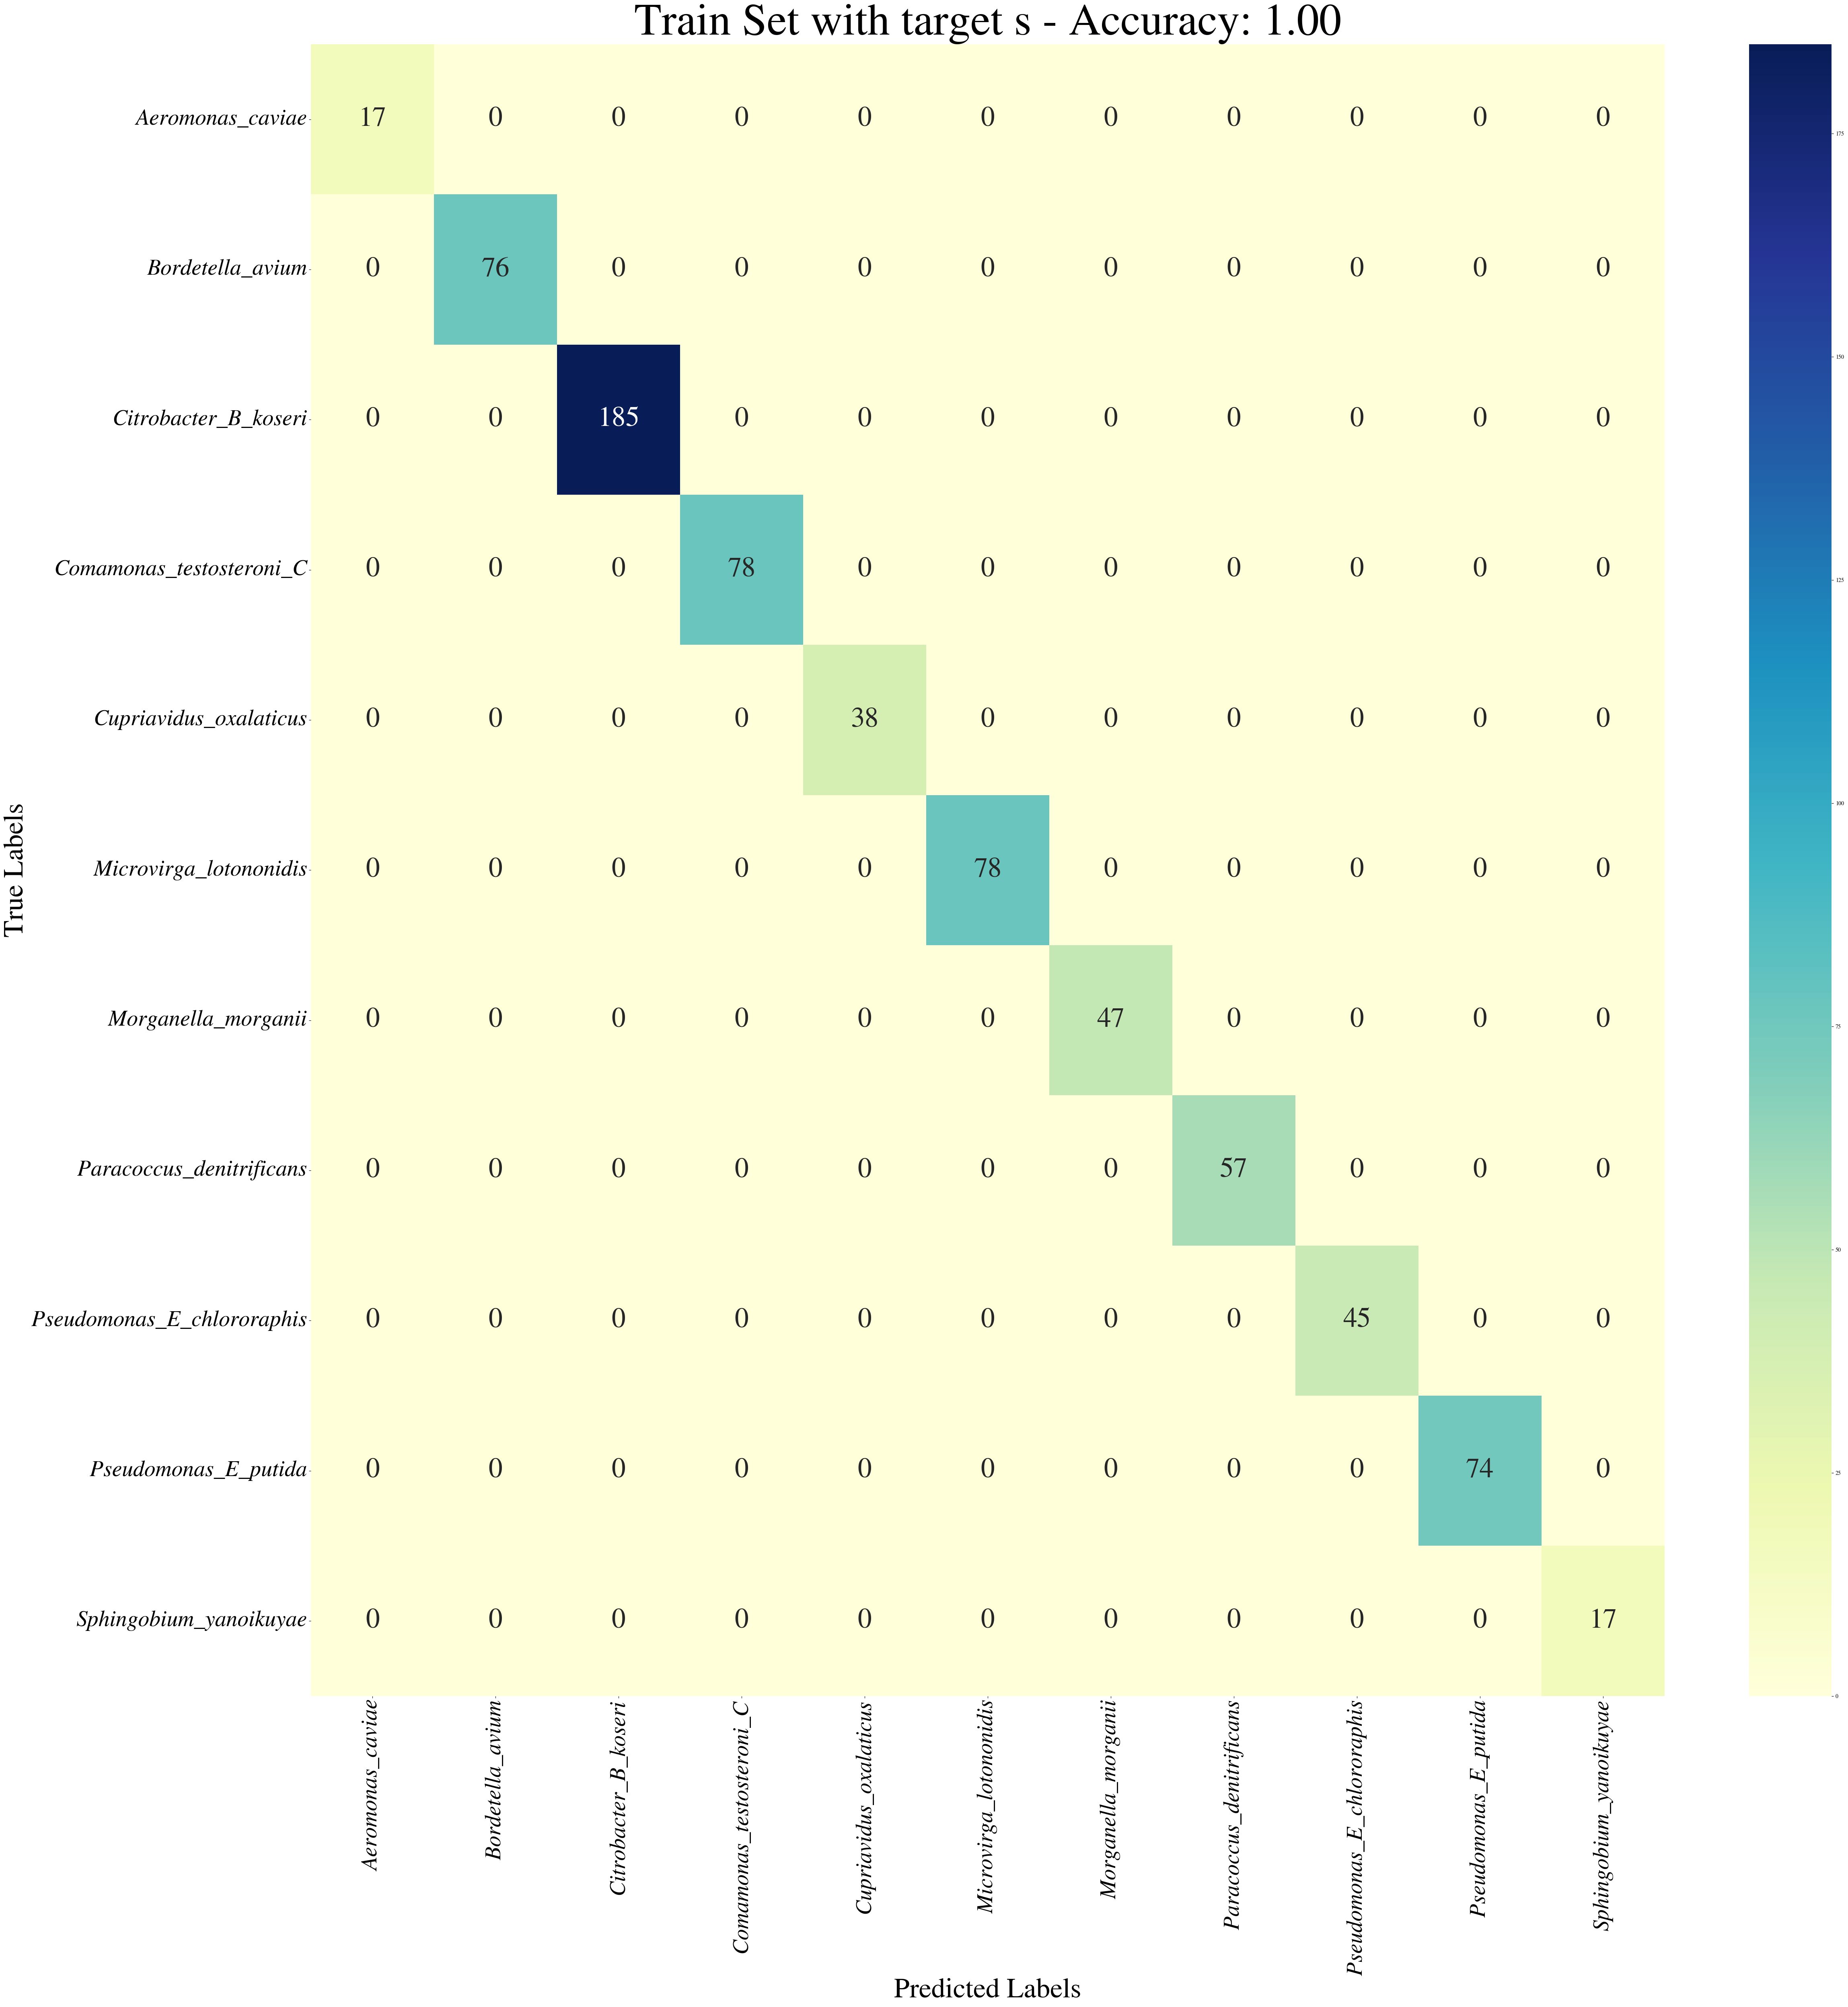

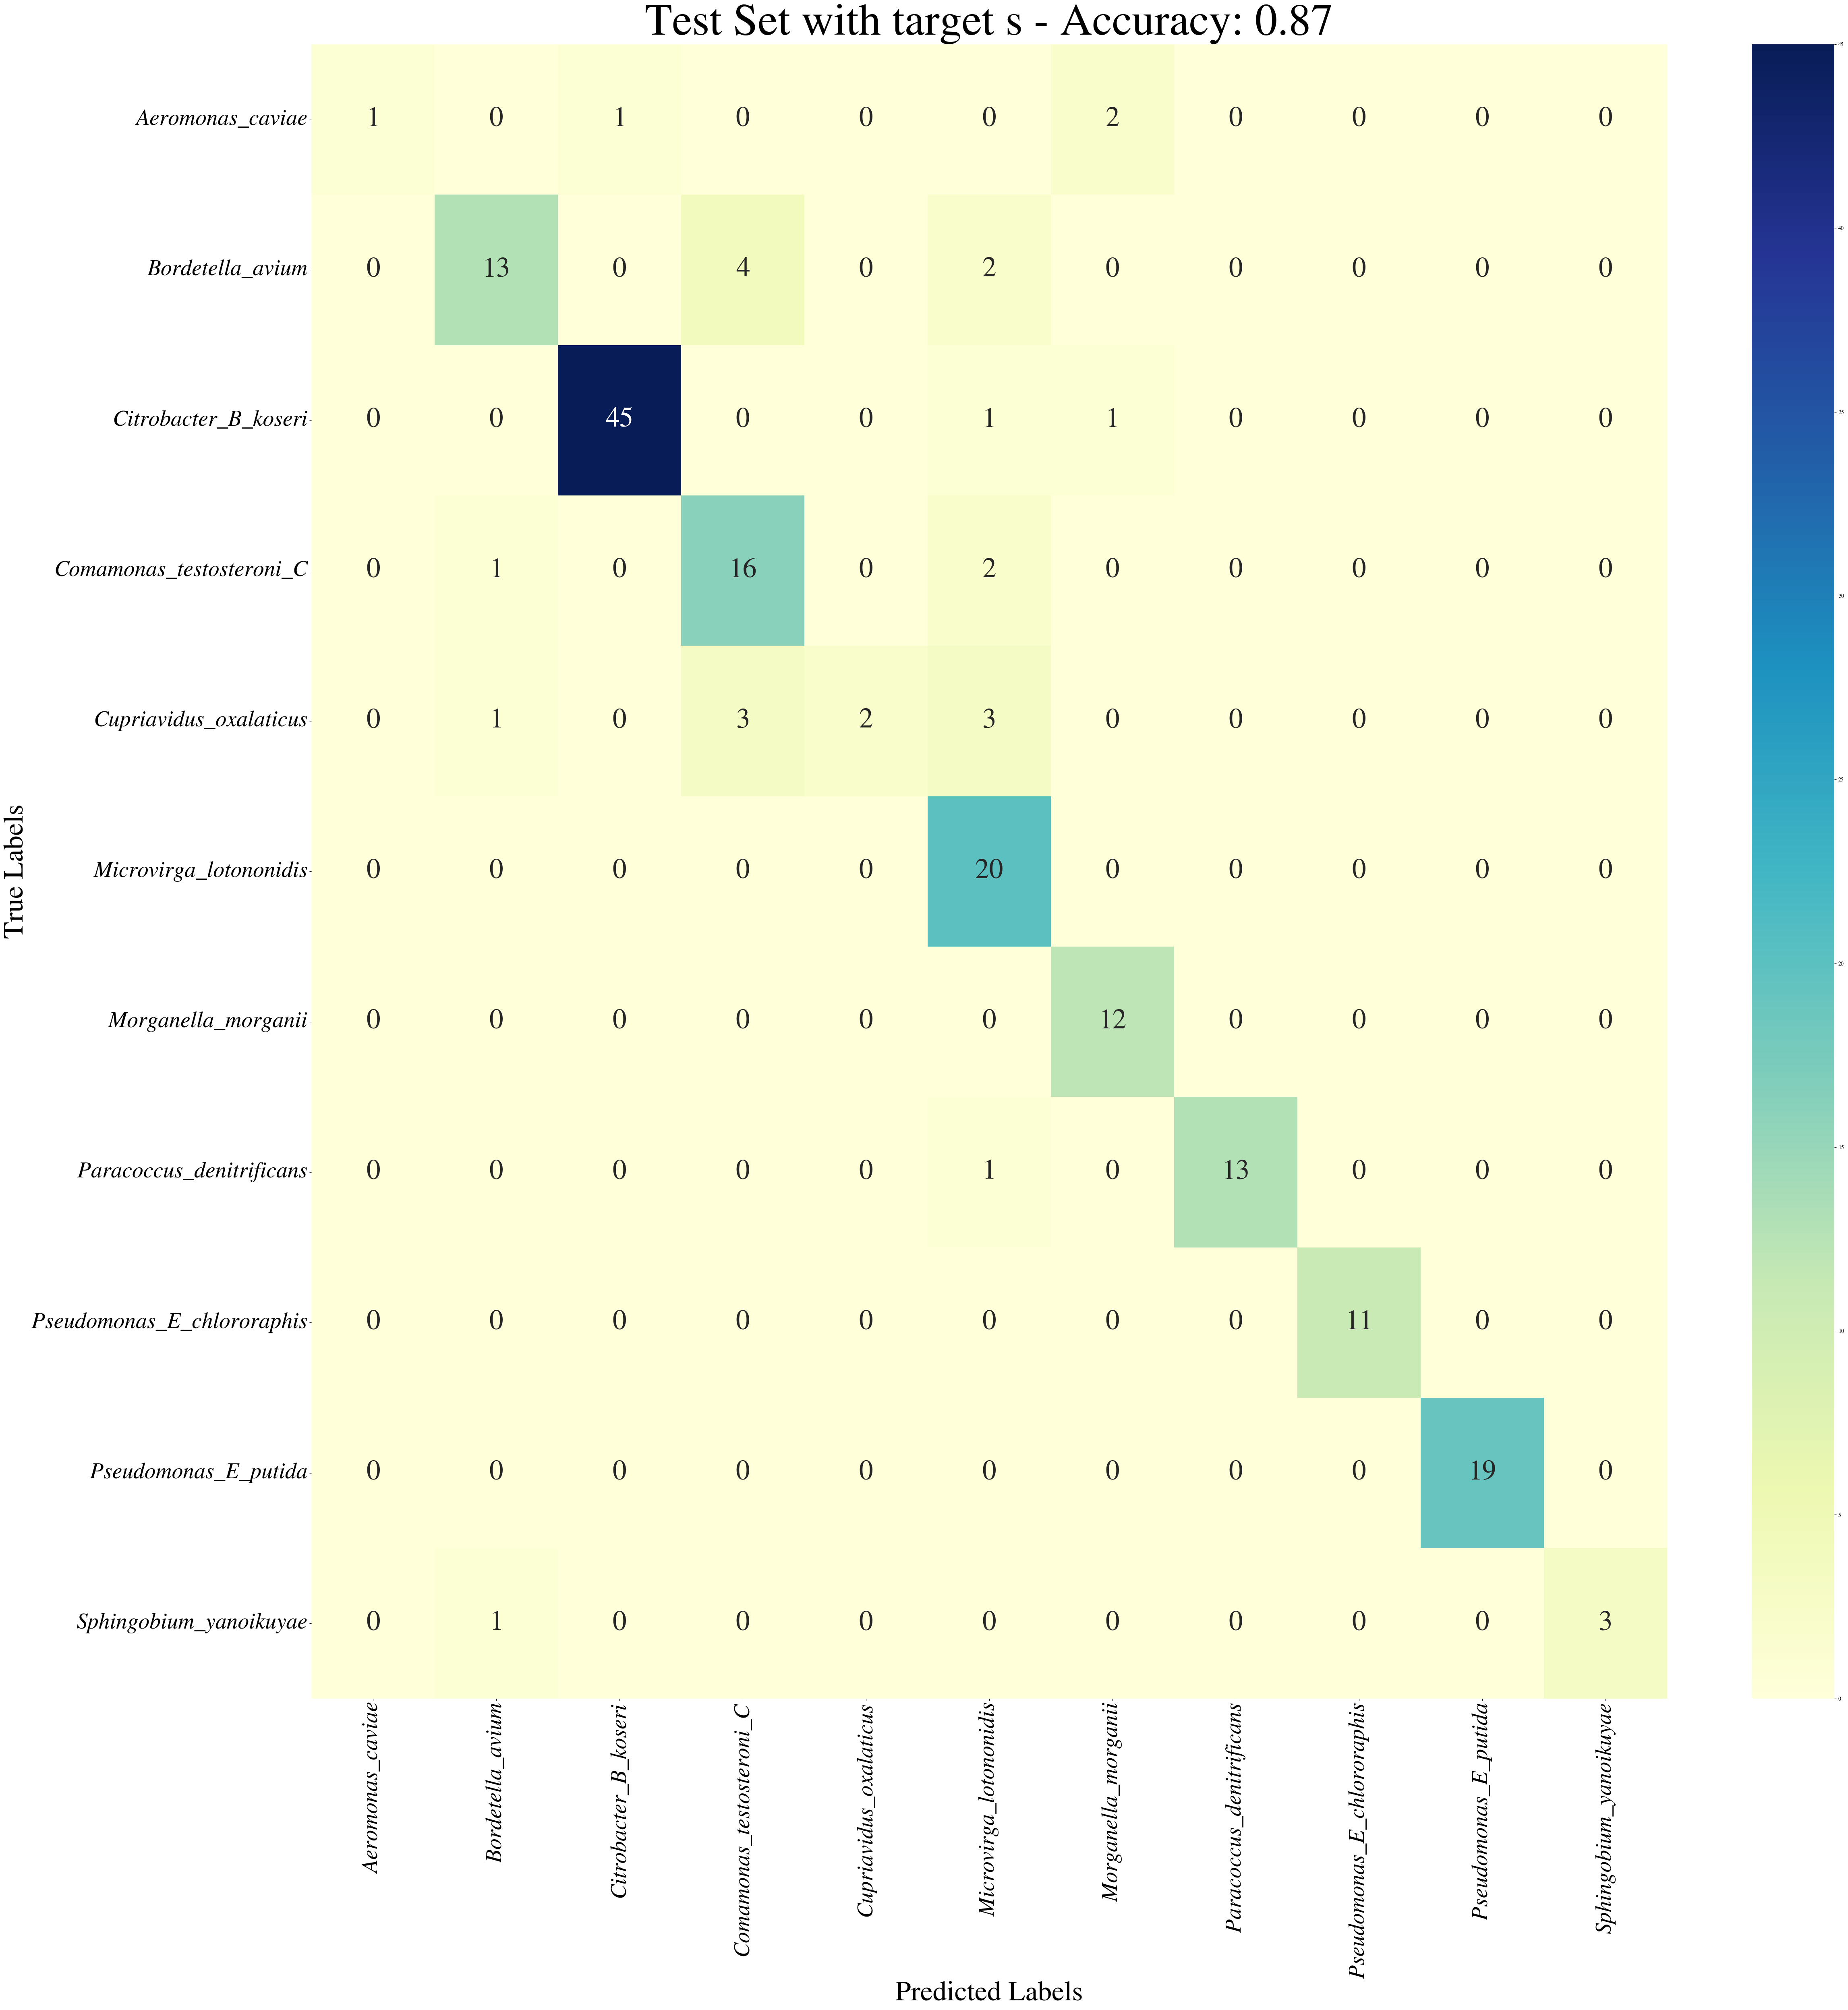

Metrics for target s
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.893406  0.870787   0.85871
Model trained with accuracy: 0.8707865168539326
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/s_model.joblib


In [95]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

y_test_DS, y_test_pred_DS = train_test_model(data, output_folder, 's')

In [ ]:
len(np.unique(y_test_pred_DS))

In [ ]:
train_test_model(data, output_folder, 'g')

In [ ]:
train_test_model(data, output_folder, 'f')

In [ ]:
train_test_model(data, output_folder, 'o')

In [ ]:
train_test_model(data, output_folder, 'c')

In [ ]:
train_test_model(data, output_folder, 'p')

## Exploring different number of lines in .gff files
### 20, 50, 100, 200, 500

In [ ]:
data = pd.read_csv("/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv", sep="\t", index_col=0, header=0,low_memory=False)

In [ ]:
data.head()

In [ ]:
## Delete all rows with < 50 / < 100 / < 200 / < 500 mod counts
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_mod_counts.tsv'

df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_mod_counts.shape[0])
df_mod_counts.head()

## Append to merged_data.tsv
data_ext = data.copy()
data_mod_counts = pd.concat([data_ext, df_mod_counts], axis=1)
data_mod_counts.head()

data_mod_counts = data_mod_counts.loc[data_mod_counts['mod_count'] >= 50]
#data_mod_counts = data_mod_counts.loc[data_mod_counts['mod_count'] >= 100]
#data_mod_counts = data_mod_counts.loc[data_mod_counts['mod_count'] >= 200]
#data_mod_counts = data_mod_counts.loc[data_mod_counts['mod_count'] >= 500]

print(data_mod_counts.shape[0])

#len(data_mod_counts['Domain to species'].value_counts(dropna=True))
len(data_mod_counts['Domain to species'].value_counts(dropna=False))

## Random forest classifier 
#### Filtered by mod counts
##### > 50
##### > 100
##### > 200
##### > 500

In [215]:
def clean_data(data_mod_counts: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data_mod_counts['s'].unique())
    print(f"before filtering number of classes {len(data_mod_counts['s'].value_counts())}")   
    data_mod_counts_filtered = data_mod_counts.dropna(subset=['All'], axis=0)
    data_mod_counts_filtered = data_mod_counts_filtered[(data_mod_counts_filtered['All'] != '') & (data_mod_counts_filtered['All'] != 'Bacteria')]
    data_mod_counts_filtered = data_mod_counts_filtered[(data_mod_counts_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"after filtering number of classes {len(data_mod_counts_filtered['s'].value_counts())}")
    classes_after = set(data_mod_counts_filtered['s'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_mod_counts_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    """Filter out the contigs that have less than n samples in the given column.
    
    Parameters:
    - data (pd.DataFrame): Data frame with the data.
    - column_name (str): Column name to filter out.
    - n (int): Minimum number of samples.
    """
    print(f"before filtering number of classes {len(data_mod_counts[column_name].value_counts())}")
    counts = data_mod_counts[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data_mod_counts = data_mod_counts[data_mod_counts[column_name].isin(classes)]
    filtered_data_mod_counts = filtered_data_mod_counts.dropna(subset=[column_name], axis=0)
    print(f"after filtering number of classes {len(filtered_data_mod_counts[column_name].value_counts())}")

    return filtered_data_mod_counts

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model: RandomForestClassifier, title: str, output_dir: str, target: str):
    """Plot the confusion matrix for the given true and predicted values.
    
    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (pd.Series): Predicted labels.
    - model (RandomForestClassifier): Trained model.
    - title (str): Title of the plot.
    - output_dir (str): Path to the output directory where the plot will be saved.
    - target (str): Target column.
    """

    cm = confusion_matrix(y_true, y_pred)

    # Replace zeros with np.nan to mask them
    cm_nan = cm.astype(float)
    cm_nan[cm_nan == 0] = np.nan

    # Copy the colormap and set the color for NaNs (bad values)
    base_cmap = copy(plt.get_cmap("YlGnBu"))
    base_cmap.set_bad(color="#FFFFF7")  # light gray for NaN

    # Prepare annotation: show numbers except for NaNs (which become empty strings)
    annot = np.where(np.isnan(cm_nan), "", cm_nan.astype(int).astype(str))
    
    # Replace underscores with spaces
    clean_labels = [label.replace("_", " ") for label in model.classes_]
    
    plt.figure(figsize=(50, 50))
    
    #sns.heatmap(masked_data, annot=True, fmt='d', cmap=custom_cmap, # OR cmap='BuGn'
    #            xticklabels=clean_labels, yticklabels=clean_labels,
    #            cbar=True, annot_kws={"size": 60},
    #            cbar_kws={'label': 'Number of predictions', 'shrink': 0.8, 'aspect': 30, 'orientation': 'vertical'})

    sns.heatmap(cm_nan, cmap=base_cmap, annot=annot, fmt='',
    xticklabels=clean_labels, yticklabels=clean_labels, cbar=True, annot_kws={"size": 60}, cbar_kws={
        'label': '',
        'shrink': 0.8,
        'aspect': 30,
        'orientation': 'vertical'})

    plt.xticks(rotation = 40, ha='right', fontsize=60, fontstyle='italic')
    plt.yticks(rotation=0, fontsize=60, fontstyle='italic')

    # Edit legend labels
    ax = plt.gca()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=60)

    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}', fontsize=110)
    xticklabels=clean_labels,
    yticklabels=clean_labels,
    plt.xlabel('Predicted labels', fontsize=80, fontweight='bold')
    plt.ylabel('True labels', fontsize=80, fontweight='bold')
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    title = title.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.savefig(os.path.join(output_dir, f'{title}.svg'))

    # Edit when you have chosen the number of features
    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat.png'), bbox_inches='tight')
    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat.svg'), bbox_inches='tight')
    plt.show()
    
    plt.close()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, output_dir: str, target: str):
    """Plot the distribution of the train and test sets.
    
    Parameters:
    - y_train (pd.Series): True labels of the train set.
    - y_test (pd.Series): True labels of the test set.
    - output_dir (str): Path to the output directory.
    """
    print("Plotting the distribution")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    print("Number of samples in each species in the train set:")
    print(train_species_counts)
    print("\nNumber of samples in each species in the test set:")
    print(test_species_counts)
    num_classes = len(set(y_train.unique()).union(set(y_test.unique())))
    
    width = max(12, num_classes * 0.6)
    height = max(8, num_classes * 0.8)
    
    plt.figure(figsize=(width, height))
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    # Replace underscores with spaces
    labels = ["Citrobacter_B_koseri", "Pseudomonas_E_putida", "Bordetella_avium", "Microvirga_lotononidis",
              "Paracoccus_denitrificans", "Comamonas_testosteroni_C", "Pseudomonas_E_chlororaphis", "Morganella_morganii",
              "Cupriavidus_oxalaticus", "Sphingobium_yanoikuyae", "Aeromonas_caviae"]
    clean_labels = [label.replace("_", " ") for label in labels]

    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, clean_labels, fontsize=16, fontstyle='italic', rotation = 40, ha='right')
    plt.yticks(fontsize=16)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.title(f'Distribution of train and test set data', fontsize=30)
    plt.subplots_adjust(bottom=0.3)
    
    target = target.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.png'), bbox_inches='tight')
    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.svg'))
    plt.show()

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target:str, top_n: int = 30, output_dir: str = None):
    """Plot the feature importance of the model.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    - output_dir (str): Path to the output directory.
    """
    
    methylation_colors = {'m6A': '#BF5137',
                          'm4C': '#365E46',
                          'modified_base': '#ABC7C9',
                          'other': 'gray'}

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    top_features = X.columns[top_indices]

    def get_color(feature_name):
        if 'm6A' in feature_name:
            return methylation_colors['m6A']
        elif 'm4C' in feature_name:
            return methylation_colors['m4C']
        elif 'modified_base' in feature_name:
            return methylation_colors['modified_base']
        else:
            return methylation_colors['other']

    bar_colors = [get_color(feature) for feature in top_features]

    plt.figure(figsize=(20, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color=bar_colors)
    plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right', fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f"Top {top_n} features with species", fontsize=50)
    plt.xlim(-0.5, len(top_indices) - 0.5)
    plt.tight_layout()
    output_name = f'{target.replace(" ", "_")}_feature_importance_colors.png'
    plt.savefig(os.path.join(output_dir, f'{target}_feature_importance_colors.png'))
    plt.savefig(os.path.join(output_dir, f'{target}_feature_importance_colors.svg'))
    plt.close()

def train_test_model(df: pd.DataFrame, output_folder: str, target: str):
    """Train and test the random forest classifier.

    Parameters:
    - df (pd.DataFrame): Data frame with the data.
    - output_folder (str): Path to the output directory to save the results for the model plots
    - target (str): Target column.
    """
    print(f"Training the model with target: {target}")
    filtered_data_mod_counts = clean_data(df)
    filtered_data_mod_counts = filter_out_n(filtered_data_mod_counts, target, 10)
    
    X_DS = filtered_data_mod_counts.iloc[:, :492] 
    y_DS = filtered_data_mod_counts[target]

    X_train_DS, X_test_DS, y_train_DS, y_test_DS = train_test_split(X_DS, y_DS, test_size=0.2, random_state=seed, stratify=y_DS)
    plot_train_test_distribution(y_train_DS, y_test_DS, output_folder, target)
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train_DS, y_train_DS)

    y_train_pred_DS = model.predict(X_train_DS)
    y_test_pred_DS = model.predict(X_test_DS)

    labels = ["Citrobacter_B_koseri", "Pseudomonas_E_putida", "Bordetella_avium", "Microvirga_lotononidis",
              "Paracoccus_denitrificans", "Comamonas_testosteroni_C", "Pseudomonas_E_chlororaphis", "Morganella_morganii",
              "Cupriavidus_oxalaticus", "Sphingobium_yanoikuyae", "Aeromonas_caviae"]

    # Replace underscores with spaces
    clean_labels = [label.replace("_", " ") for label in labels]

    plot_confusion_matrix(y_train_DS, y_train_pred_DS, model, f'Train Set with species', output_folder, target)
    plot_confusion_matrix(y_test_DS, y_test_pred_DS, model, f'Test Set with species', output_folder, target)

    plot_feature_importance(model, X_DS, target, 30, output_folder)

    metrics = pd.DataFrame({
            'Accuracy Train': [accuracy_score(y_train_DS, y_train_pred_DS)],
            'Accuracy Test': [accuracy_score(y_test_DS, y_test_pred_DS)],
            'Precision': [precision_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'Recall': [recall_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'F1 Score': [f1_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)]
        })
    
    metrics.to_csv(os.path.join(output_folder, f'{target.replace(" ", "_")}_metrics.tsv'), sep='\t')
    print(f"Metrics for target {target}")
    print(metrics)

    if accuracy_score(y_test_DS, y_test_pred_DS) > 0.7:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
        model_file_path = os.path.join(output_folder, f'{target.replace(" ", "_")}_model.joblib')
        print(f"Saving the model to {model_file_path}")
        joblib.dump(model, model_file_path)
    else:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
    return y_test_DS, y_test_pred_DS
    

Training the model with target: s
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 15
after filtering number of classes 11
Plotting the distribution
Number of samples in each species in the train set:
s
Citrobacter_B_koseri          179
Pseudomonas_E_putida           74
Bordetella_avium               57
Microvirga_lotononidis         54
Paracoccus_denitrificans       47
Comamonas_testosteroni_C       46
Pseudomonas_E_chlororaphis     45
Morganella_morganii            39
Cupriavidus_oxalaticus         17
Sphingobium_yanoikuyae         15
Aeromonas_caviae               12
Name: count, dtype: int64

Number of samples in each species in the test set:
s
Citrobacter_B_koseri          45
Pseudomonas_E_putida          19
Microvirga_lotononidis        14
Bordetella_avium              14
Comamonas_testosteroni_C      12
Paracoccus_denitrificans      12
Pseudomonas_E_chlororaphis    11
Morganella_morganii         

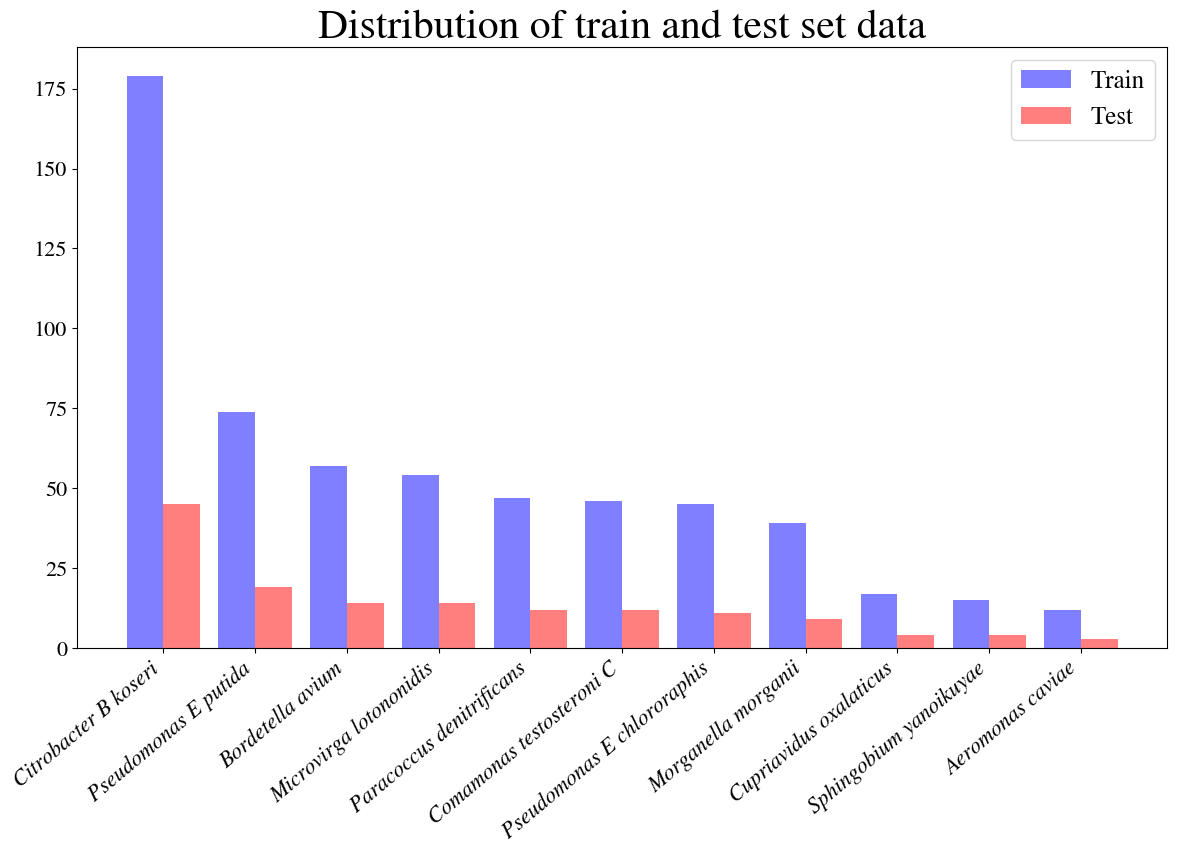

/tmp/markkan5/29151154/ipykernel_1899121/526296421.py:56: RuntimeWarning: invalid value encountered in cast
  annot = np.where(np.isnan(cm_nan), "", cm_nan.astype(int).astype(str))


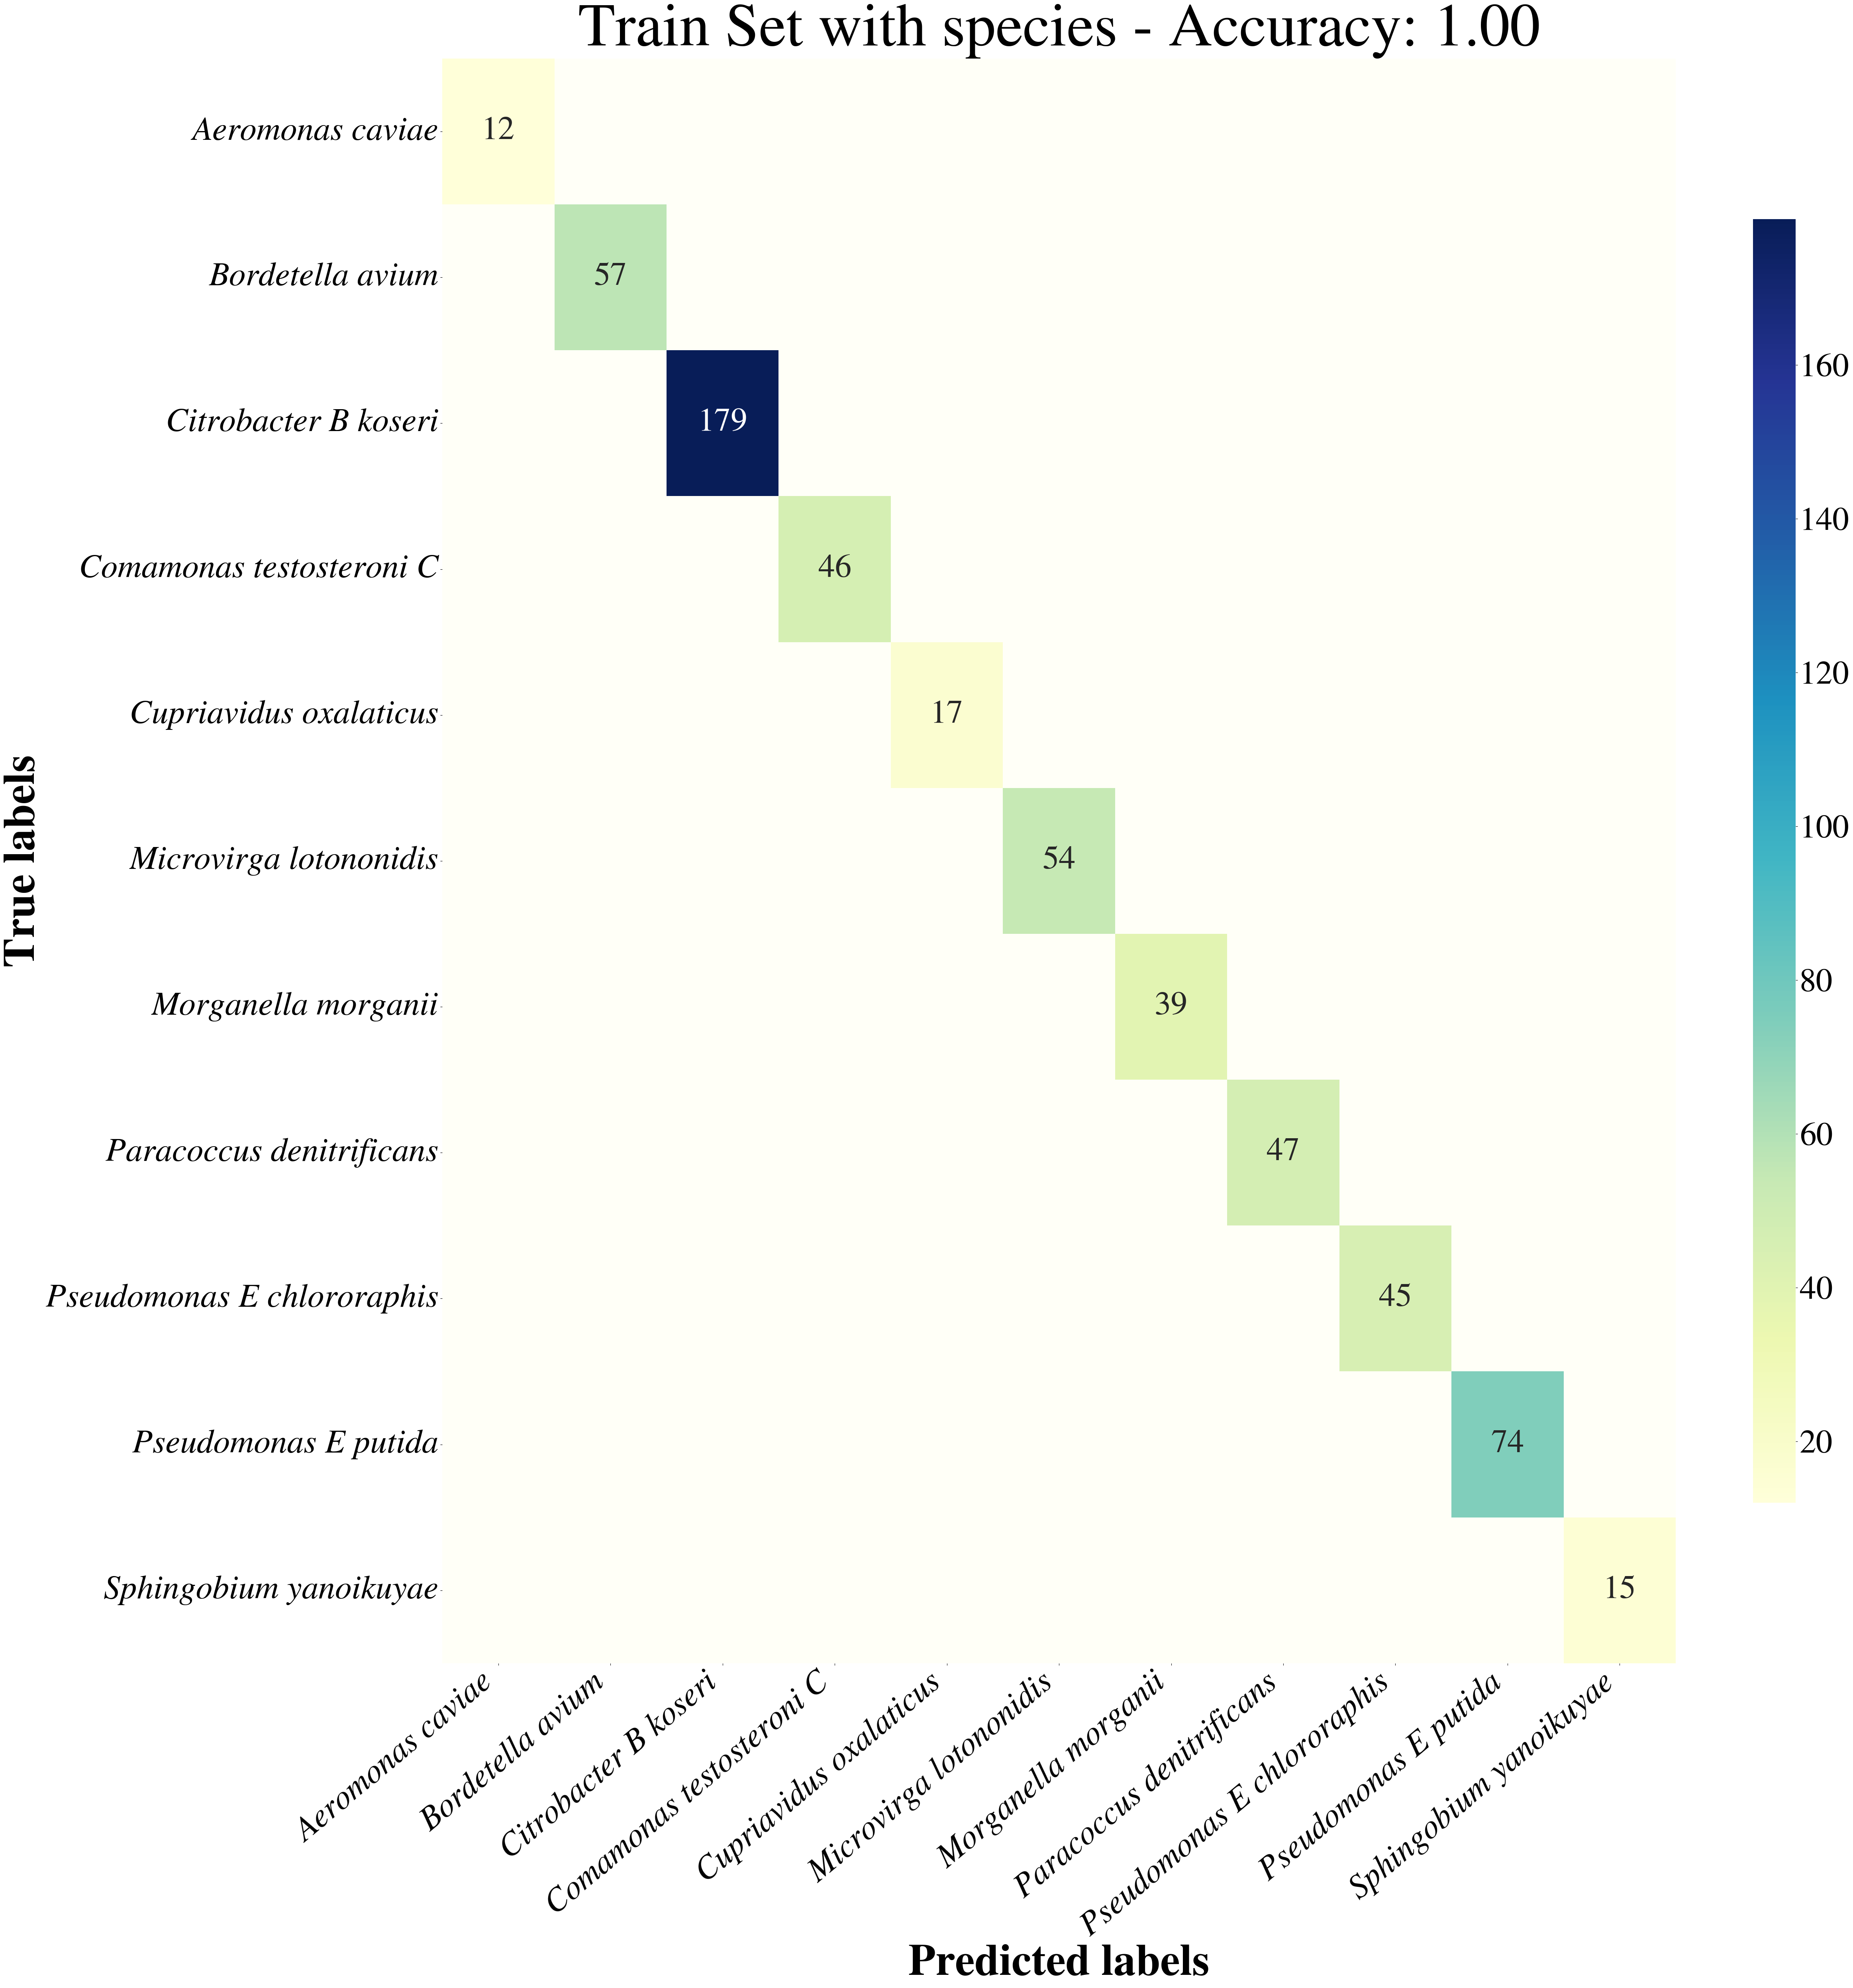

/tmp/markkan5/29151154/ipykernel_1899121/526296421.py:56: RuntimeWarning: invalid value encountered in cast
  annot = np.where(np.isnan(cm_nan), "", cm_nan.astype(int).astype(str))


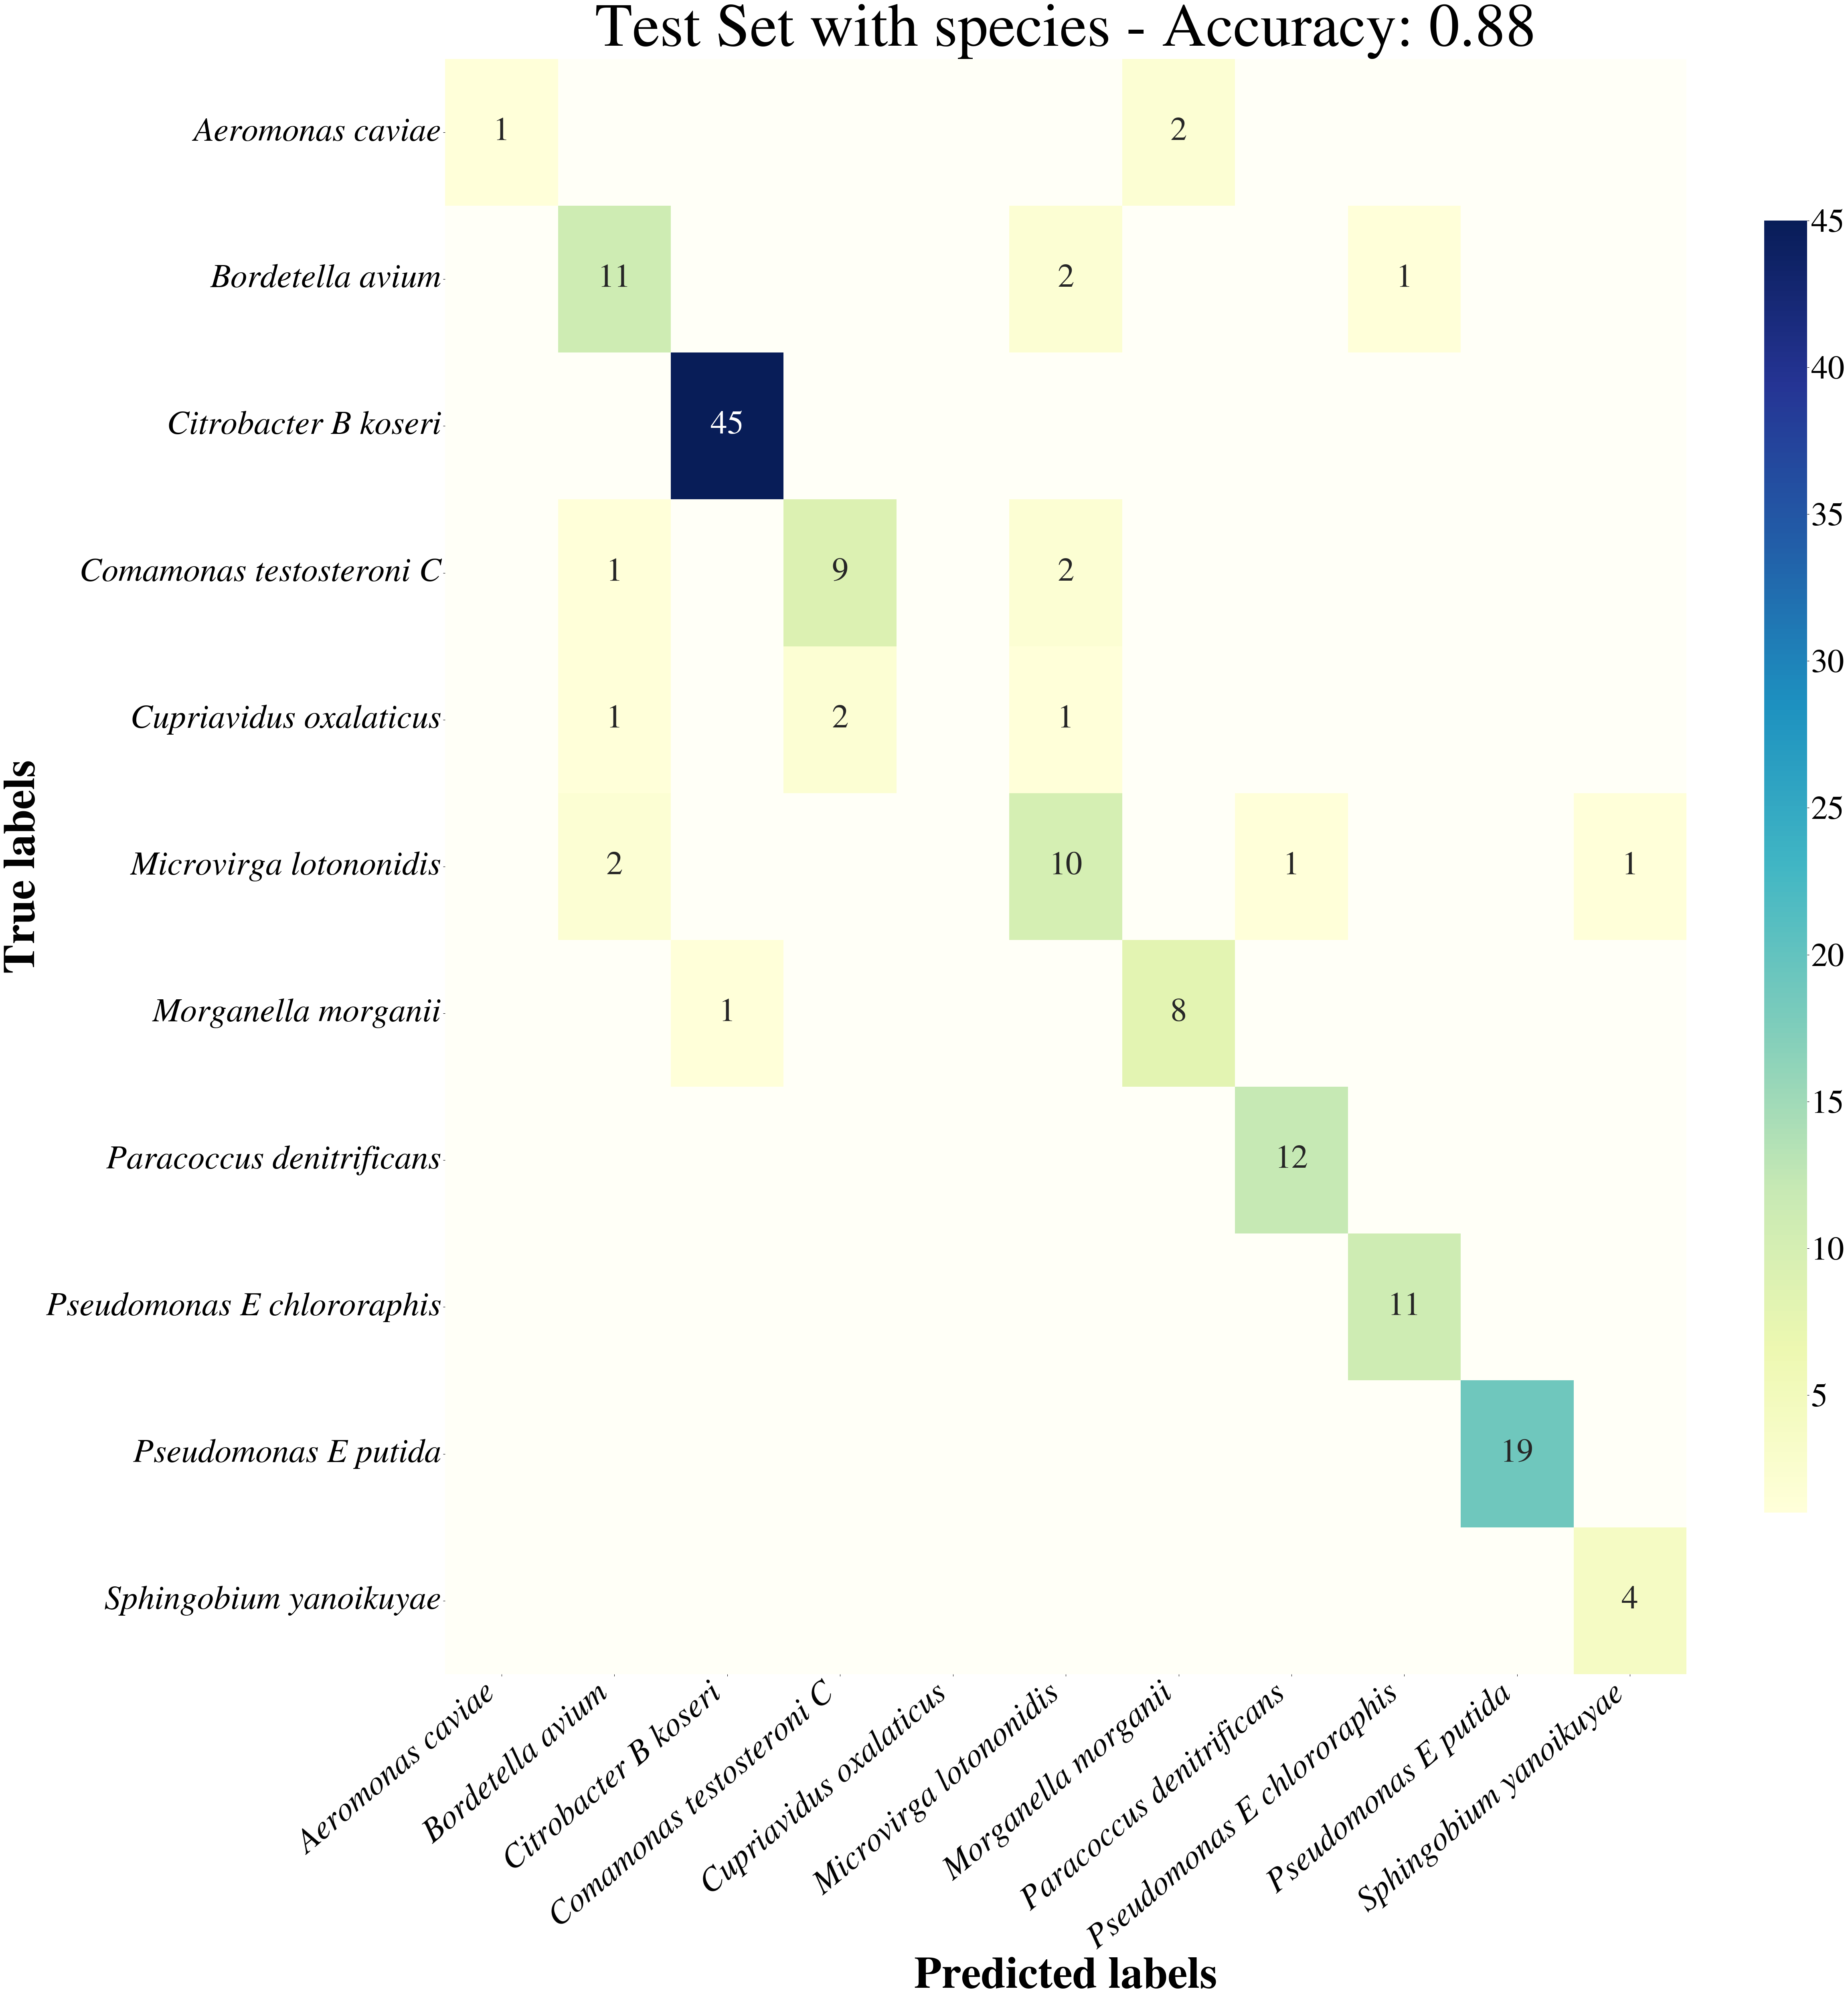

Metrics for target s
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.884354   0.863947  0.884354   0.86972
Model trained with accuracy: 0.8843537414965986
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI_above50/s_model.joblib


In [216]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI_above50'
#output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI_above100'
#output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI_above200'
#output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI_above500'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

y_test_DS, y_test_pred_DS = train_test_model(data, output_folder, 's')

In [ ]:
len(np.unique(y_test_pred_DS))

In [ ]:
train_test_model(data_mod_counts, output_folder, 'g')

In [ ]:
train_test_model(data_mod_counts, output_folder, 'f')

In [ ]:
train_test_model(data_mod_counts, output_folder, 'o')

In [ ]:
train_test_model(data_mod_counts, output_folder, 'c')

In [ ]:
train_test_model(data_mod_counts, output_folder, 'p')